# Debug FAISS Performance

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# System imports
import os
import sys
from time import time as tt
import importlib

# External imports
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch_geometric.data import DataLoader

from itertools import chain
from random import shuffle, sample
from scipy.optimize import root_scalar as root

from torch.nn import Linear
import torch.nn.functional as F
from torch_cluster import knn_graph, radius_graph
import trackml.dataset
import torch_geometric
from itertools import permutations
import itertools
from sklearn import metrics
import pytorch_lightning as pl
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.loggers import WandbLogger
from torch.utils.checkpoint import checkpoint

import faiss

sys.path.append('/global/homes/d/danieltm/ExaTrkX/Tracking-ML-Exa.TrkX/src/Pipelines/TrackML_Example')
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
from utils.stage_utils import get_resume_id, load_config, combo_config, dict_to_args, get_logger, build_model, build_trainer, autocast
from LightningModules.Embedding.Models.layerless_embedding import LayerlessEmbedding
from LightningModules.Embedding.utils import filter_hit_pt, fetch_pt, fetch_type, load_dataset, graph_intersection, build_edges

## Exploration

In [96]:
def build_edges(spatial, r_max, k_max, return_indices=False):
    
    if device == "cuda":
        res = faiss.StandardGpuResources()
        D, I = faiss.knn_gpu(res, spatial, spatial, k_max)
    elif device == "cpu":
        index = faiss.IndexFlatL2(spatial.shape[1])
        index.add(spatial)
        D, I = index.search(spatial, k_max)
        
    D, I = D[:,1:], I[:,1:]
    ind = torch.Tensor.repeat(torch.arange(I.shape[0], device=device), (I.shape[1], 1), 1).T

    edge_list = torch.stack([ind[D <= r_max**2], I[D <= r_max**2]])

    if return_indices:
        return edge_list, D, I, ind
    else:
        return edge_list
    
def build_edges_with_index(spatial, index, r_max, k_max, return_indices=False):
    
    D, I = index.search(spatial, k_max)
        
    D, I = D[:,1:], I[:,1:]
    ind = torch.Tensor.repeat(torch.arange(I.shape[0], device=device), (I.shape[1], 1), 1).T

    edge_list = torch.stack([ind[D <= r_max**2], I[D <= r_max**2]])

    if return_indices:
        return edge_list, D, I, ind
    else:
        return edge_list

def search_index_pytorch(index, x, k, D=None, I=None):
    """call the search function of an index with pytorch tensor I/O (CPU
    and GPU supported)"""
    assert x.is_contiguous()
    n, d = x.size()
    assert d == index.d

    if D is None:
        D = torch.empty((n, k), dtype=torch.float32, device=x.device)
    else:
        assert D.size() == (n, k)

    if I is None:
        I = torch.empty((n, k), dtype=torch.int64, device=x.device)
    else:
        assert I.size() == (n, k)
    torch.cuda.synchronize()
    xptr = swig_ptr_from_FloatTensor(x)
    Iptr = swig_ptr_from_LongTensor(I)
    Dptr = swig_ptr_from_FloatTensor(D)
    index.search_c(n, xptr,
                   k, Dptr, Iptr)
    torch.cuda.synchronize()
    return D, I

def swig_ptr_from_FloatTensor(x):
    assert x.is_contiguous()
    assert x.dtype == torch.float32
    return faiss.cast_integer_to_float_ptr(
        x.storage().data_ptr() + x.storage_offset() * 4)

def swig_ptr_from_LongTensor(x):
    assert x.is_contiguous()
    assert x.dtype == torch.int64, 'dtype=%s' % x.dtype
    return faiss.cast_integer_to_long_ptr(
        x.storage().data_ptr() + x.storage_offset() * 8)

In [4]:
import faiss.contrib.torch_utils

In [113]:
torch.manual_seed(10)
d = 8
nb = 100000
nq = 10
k = 500
r = 0.1

In [106]:
%%time
spatial = torch.rand(nb, d, dtype=torch.float32, device=torch.device('cuda'))

CPU times: user 76 µs, sys: 90 µs, total: 166 µs
Wall time: 172 µs


In [102]:
%%time
edge_list = build_edges(spatial, r, k)

CPU times: user 168 ms, sys: 205 ms, total: 373 ms
Wall time: 372 ms


In [107]:
%%time
gpu_index = faiss.GpuIndexFlatL2(res, d)
gpu_index.add(spatial)

CPU times: user 0 ns, sys: 1.47 ms, total: 1.47 ms
Wall time: 1.21 ms


In [105]:
%%time
edge_list = build_edges_with_index(spatial, gpu_index, r, k)

CPU times: user 190 ms, sys: 75 ms, total: 265 ms
Wall time: 265 ms


In [108]:
%%time
D, I = gpu_index.search(spatial, k)

CPU times: user 2.29 ms, sys: 0 ns, total: 2.29 ms
Wall time: 1.92 ms


In [88]:
%%time
D, I = D[:,1:], I[:,1:]
ind = torch.Tensor.repeat(torch.arange(I.shape[0]), (I.shape[1], 1), 1).T.to(device)
edge_list = torch.stack([ind[D <= r**2], I[D <= r**2]])

CPU times: user 86.4 ms, sys: 66.3 ms, total: 153 ms
Wall time: 90.8 ms


In [109]:
%%time
D, I = D[:,1:], I[:,1:]
ind = torch.Tensor.repeat(torch.arange(I.shape[0], device=device), (I.shape[1], 1), 1).T
edge_list = torch.stack([ind[D <= r**2], I[D <= r**2]])

CPU times: user 1.94 ms, sys: 0 ns, total: 1.94 ms
Wall time: 1.53 ms


In [121]:
spatial = torch.rand(nb, d, dtype=torch.float32, device=torch.device('cuda'))

In [122]:
%%time
gpu_index = faiss.GpuIndexFlatL2(res, d)
gpu_index.add(spatial)



CPU times: user 1.48 ms, sys: 0 ns, total: 1.48 ms
Wall time: 1.18 ms


In [124]:
%%time
D, I = gpu_index.search(spatial, k)

D, I = D[:,1:], I[:,1:]


CPU times: user 2.75 ms, sys: 0 ns, total: 2.75 ms
Wall time: 2.32 ms


In [126]:
%%time
ind = torch.Tensor.repeat(torch.arange(I.shape[0], device=device), (I.shape[1], 1), 1).T
edge_list = torch.stack([ind[D <= r**2], I[D <= r**2]])

CPU times: user 3.22 ms, sys: 0 ns, total: 3.22 ms
Wall time: 2.77 ms


# Indexing

## Flat Index on CPU

Make dataset

In [3]:
d = 8                           # dimension
nb = 100000                      # database size
nq = 10000                       # nb of queries
np.random.seed(0)             # make reproducible
xb = np.random.random((nb, d)).astype('float32')
xb[:, 0] += np.arange(nb) / 1000.
xq = np.random.random((nq, d)).astype('float32')
xq[:, 0] += np.arange(nq) / 1000.

Build index

In [5]:
%%time
index = faiss.IndexFlatL2(d)   # build the index
print(index.is_trained)
index.add(xb)                  # add vectors to the index
print(index.ntotal)

True
100000
CPU times: user 0 ns, sys: 2.05 ms, total: 2.05 ms
Wall time: 1.61 ms


Run search

In [188]:
%%time
for k in np.arange(1, 100, 5):
    tic = tt()
    D, I = index.search(xb, k)     # actual search
    print("{} neighbours @ {} seconds".format(k, tt()-tic))

TypeError: in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'

In [7]:
k = 4
D, I = index.search(xb, k)     # actual search

## Flat Index on GPU

In [92]:
import faiss.contrib.torch_utils

In [93]:
res = faiss.StandardGpuResources()

In [42]:
%%time
k_timings = []
k_ticks = np.logspace(0, 3, num=20, base=10)
for k in k_ticks:
    tic = tt()
    D, I = faiss.knn_gpu(res, xb, xb, int(k))
    k_timing = tt()-tic
    k_timings.append(k_timing)
    print("{} neighbours @ {} seconds".format(k, k_timing))

1.0 neighbours @ 0.17615818977355957 seconds
1.4384498882876628 neighbours @ 0.17444539070129395 seconds
2.0691380811147897 neighbours @ 0.18125152587890625 seconds
2.976351441631318 neighbours @ 0.1811387538909912 seconds
4.281332398719393 neighbours @ 0.18437409400939941 seconds
6.158482110660264 neighbours @ 0.1883237361907959 seconds
8.858667904100825 neighbours @ 0.18972206115722656 seconds
12.742749857031335 neighbours @ 0.19418931007385254 seconds
18.329807108324356 neighbours @ 0.20281219482421875 seconds
26.366508987303583 neighbours @ 0.21146202087402344 seconds
37.926901907322495 neighbours @ 0.22797703742980957 seconds
54.55594781168517 neighbours @ 0.25095248222351074 seconds
78.47599703514611 neighbours @ 0.28458690643310547 seconds
112.88378916846884 neighbours @ 0.3595256805419922 seconds
162.3776739188721 neighbours @ 0.4506218433380127 seconds
233.57214690901213 neighbours @ 0.5582706928253174 seconds
335.9818286283781 neighbours @ 0.8598945140838623 seconds
483.29302

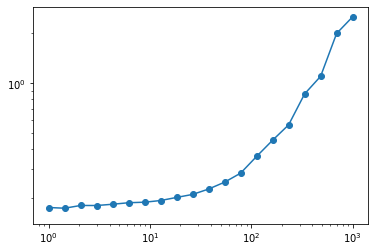

In [43]:
plt.scatter(k_ticks, k_timings)
plt.plot(k_ticks, k_timings)
plt.xscale("log")
plt.yscale("log")

In [44]:
k_brute_gpu_timings = k_timings

So already we're down two orders of magnitude, but we want ONE more order of magnitude speed-up!

## Voronoi Index on CPU

Build index:

In [69]:
%%time
nlist = 100
quantizer = faiss.IndexFlatL2(d)  # the other index
index = faiss.IndexIVFFlat(quantizer, d, nlist)
assert not index.is_trained
index.train(xb)
assert index.is_trained

CPU times: user 493 ms, sys: 721 µs, total: 494 ms
Wall time: 418 ms


Add to index:

In [70]:
%%time
index.add(xb)                  # add may be a bit slower as well

CPU times: user 44.9 ms, sys: 551 µs, total: 45.5 ms
Wall time: 30.9 ms


Search index

In [71]:
%%time
k_timings = []
for k in k_ticks:
    tic = tt()
    index.remove_ids(np.arange(index.ntotal, dtype='int64'))
    index.add(xb)                  # add may be a bit slower as well
    
    index.nprobe = 1              # default nprobe is 1, try a few more
    D, I = index.search(xb, int(k))
    
    k_timing = tt()-tic
    k_timings.append(k_timing)
    
    print("{} neighbours @ {} seconds".format(k, k_timing))

1.0 neighbours @ 0.8938710689544678 seconds
1.4384498882876628 neighbours @ 0.876331090927124 seconds
2.0691380811147897 neighbours @ 0.8825416564941406 seconds
2.976351441631318 neighbours @ 0.8898870944976807 seconds
4.281332398719393 neighbours @ 0.9190943241119385 seconds
6.158482110660264 neighbours @ 0.922710657119751 seconds
8.858667904100825 neighbours @ 0.9409420490264893 seconds
12.742749857031335 neighbours @ 1.041151523590088 seconds
18.329807108324356 neighbours @ 1.109616994857788 seconds
26.366508987303583 neighbours @ 1.2541930675506592 seconds
37.926901907322495 neighbours @ 1.4665491580963135 seconds
54.55594781168517 neighbours @ 1.615947961807251 seconds
78.47599703514611 neighbours @ 1.97585129737854 seconds
112.88378916846884 neighbours @ 2.3631577491760254 seconds
162.3776739188721 neighbours @ 2.9718120098114014 seconds
233.57214690901213 neighbours @ 3.639375925064087 seconds
335.9818286283781 neighbours @ 4.468969106674194 seconds
483.2930238571752 neighbours 

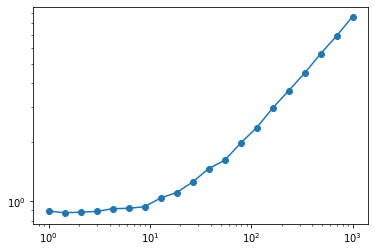

In [72]:
plt.scatter(k_ticks, k_timings)
plt.plot(k_ticks, k_timings)
plt.xscale("log")
plt.yscale("log")

In [73]:
k_voronoi_cpu_timings = k_timings

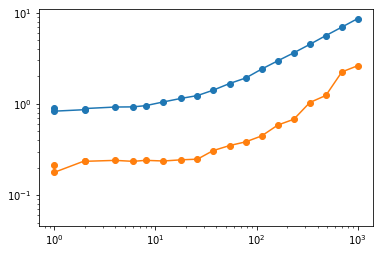

In [67]:
plt.scatter(k_ticks, k_voronoi_cpu_timings)
plt.plot(k_ticks, k_voronoi_cpu_timings)
plt.scatter(k_ticks, k_flat_gpu_timings)
plt.plot(k_ticks, k_flat_gpu_timings)
plt.xscale("log")
plt.yscale("log")

About one order of magnitude improvement.

## Voronoi Index on GPU

In [117]:
res = faiss.StandardGpuResources()

In [118]:
index = faiss.index_factory(d, "IVF16384,PQ8")

In [76]:
index = faiss.index_factory(d, "IVF16384, Flat")

In [119]:
co = faiss.GpuClonerOptions()
co.useFloat16 = True

In [120]:
%%time
index = faiss.index_cpu_to_gpu(res, 0, index, co)

CPU times: user 445 µs, sys: 104 ms, total: 105 ms
Wall time: 104 ms


In [32]:
%%time
# xb_pt = torch.from_numpy(xb).half().to(device)
xb_pt = torch.from_numpy(xb).to(device)

CPU times: user 1.46 ms, sys: 0 ns, total: 1.46 ms
Wall time: 1.05 ms


In [33]:
%%time
# print("train")
index.train(xb_pt)

ValueError: input not a numpy array

In [121]:
%%time
# print("train")
index.train(xb)

CPU times: user 5.78 s, sys: 67.7 ms, total: 5.85 s
Wall time: 3.22 s


In [75]:
%%time
# print("add vectors to index")
index.add(xb_pt)

CPU times: user 51 ms, sys: 0 ns, total: 51 ms
Wall time: 50.3 ms


In [122]:
%%time
# print("add vectors to index")
index.add(xb)

CPU times: user 223 ms, sys: 3.84 ms, total: 227 ms
Wall time: 227 ms


In [123]:
%%time
print("warmup")
index.search(xb, 123)

warmup
CPU times: user 123 ms, sys: 96.8 ms, total: 220 ms
Wall time: 219 ms


(array([[2.14576721e-06, 2.39330292e-01, 3.43187094e-01, ...,
         3.40282347e+38, 3.40282347e+38, 3.40282347e+38],
        [3.75509262e-06, 1.24549985e-01, 1.83267117e-01, ...,
         3.40282347e+38, 3.40282347e+38, 3.40282347e+38],
        [2.82645226e-04, 3.82205963e-01, 6.83759809e-01, ...,
         3.40282347e+38, 3.40282347e+38, 3.40282347e+38],
        ...,
        [1.07288361e-06, 1.51507139e-01, 1.66429520e-01, ...,
         3.40282347e+38, 3.40282347e+38, 3.40282347e+38],
        [5.42402267e-06, 1.88787460e-01, 5.22396088e-01, ...,
         3.40282347e+38, 3.40282347e+38, 3.40282347e+38],
        [1.13248825e-06, 1.45956993e-01, 1.66389108e-01, ...,
         3.40282347e+38, 3.40282347e+38, 3.40282347e+38]], dtype=float32),
 array([[    0,    13,    27, ...,    -1,    -1,    -1],
        [    1,   221,   824, ...,    -1,    -1,    -1],
        [    2,   197,   174, ...,    -1,    -1,    -1],
        ...,
        [99997, 99179, 99844, ...,    -1,    -1,    -1],
        [

In [124]:
k_timings = []
for k in k_ticks:
    tic = tt()
    index.setNumProbes(1)
    
    index.search(xb, int(k))
    k_timing = tt()-tic
    k_timings.append(k_timing)
    print("{} neighbours @ {} seconds".format(k, k_timing))

1.0 neighbours @ 0.05383181571960449 seconds
1.4384498882876628 neighbours @ 0.05355072021484375 seconds
2.0691380811147897 neighbours @ 0.055022478103637695 seconds
2.976351441631318 neighbours @ 0.05550742149353027 seconds
4.281332398719393 neighbours @ 0.05641770362854004 seconds
6.158482110660264 neighbours @ 0.05749797821044922 seconds
8.858667904100825 neighbours @ 0.058641910552978516 seconds
12.742749857031335 neighbours @ 0.059667348861694336 seconds
18.329807108324356 neighbours @ 0.06262660026550293 seconds
26.366508987303583 neighbours @ 0.06692790985107422 seconds
37.926901907322495 neighbours @ 0.07254457473754883 seconds
54.55594781168517 neighbours @ 0.11180305480957031 seconds
78.47599703514611 neighbours @ 0.13988804817199707 seconds
112.88378916846884 neighbours @ 0.20987677574157715 seconds
162.3776739188721 neighbours @ 0.28052544593811035 seconds
233.57214690901213 neighbours @ 0.37480878829956055 seconds
335.9818286283781 neighbours @ 0.5387451648712158 seconds
4

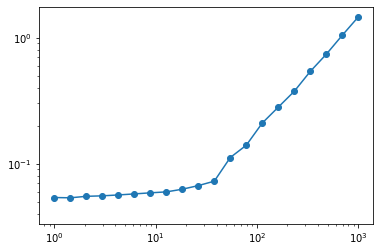

In [125]:
plt.scatter(k_ticks, k_timings)
plt.plot(k_ticks, k_timings)
plt.xscale("log")
plt.yscale("log")

In [126]:
k_voronoiPQ_big_gpu_timings = k_timings

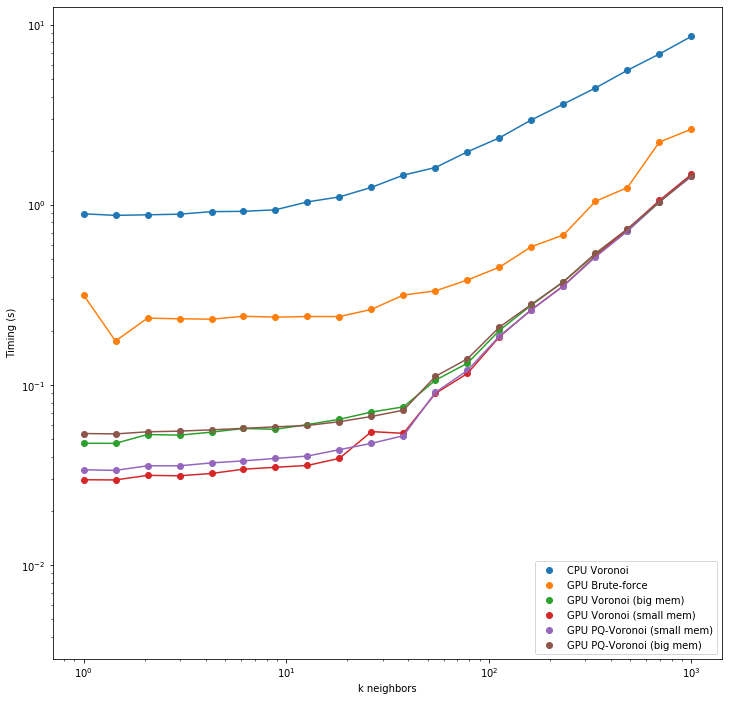

In [127]:
plt.figure(figsize=(12,12))
ax = plt.subplot()
ax.scatter(k_ticks, k_voronoi_cpu_timings, label="CPU Voronoi")
ax.plot(k_ticks, k_voronoi_cpu_timings)
ax.scatter(k_ticks, k_brute_gpu_timings, label="GPU Brute-force")
ax.plot(k_ticks, k_brute_gpu_timings)
ax.scatter(k_ticks, k_voronoi_big_gpu_timings, label="GPU Voronoi (big mem)")
ax.plot(k_ticks, k_voronoi_big_gpu_timings)
ax.scatter(k_ticks, k_voronoi_small_gpu_timings, label="GPU Voronoi (small mem)")
ax.plot(k_ticks, k_voronoi_small_gpu_timings)
ax.scatter(k_ticks, k_voronoiPQ_small_gpu_timings, label="GPU PQ-Voronoi (small mem)")
ax.plot(k_ticks, k_voronoiPQ_small_gpu_timings)
ax.scatter(k_ticks, k_voronoiPQ_big_gpu_timings, label="GPU PQ-Voronoi (big mem)")
ax.plot(k_ticks, k_voronoiPQ_big_gpu_timings)
plt.xscale("log")
plt.yscale("log")

ax.set_xlabel("k neighbors")
ax.set_ylabel("Timing (s)")
legend = ax.legend(loc='lower right')

In [177]:
%%time
print("benchmark")

for lnprobe in range(7):
    tic = tt()
    
    nprobe = 1 << lnprobe
    index.setNumProbes(nprobe)
    
    index.search(xb, k)
    
    print("{} probes takes {}ms".format(nprobe, (tt() - tic)*1000))

benchmark
1 probes takes 39.51668739318848ms
2 probes takes 41.14842414855957ms
4 probes takes 46.82207107543945ms
8 probes takes 62.059640884399414ms
16 probes takes 86.59911155700684ms
32 probes takes 124.85814094543457ms
64 probes takes 219.1922664642334ms
CPU times: user 487 ms, sys: 136 ms, total: 623 ms
Wall time: 621 ms


In [137]:
%%time
print("benchmark")

for lnprobe in range(7):
    tic = tt()
    
    nprobe = 1 << lnprobe
    index.setNumProbes(nprobe)
    
    index.search(xb_pt, k)
    
    print("{} probes takes {}ms".format(nprobe, (tt() - tic)*1000))

benchmark
1 probes takes 39.84403610229492ms
2 probes takes 43.28656196594238ms
4 probes takes 48.033952713012695ms
8 probes takes 52.45804786682129ms
16 probes takes 62.23893165588379ms
32 probes takes 78.81927490234375ms
64 probes takes 119.86136436462402ms
CPU times: user 362 ms, sys: 84.2 ms, total: 446 ms
Wall time: 445 ms


# Pytorch3D KNN

In [4]:
from pytorch3d import ops

In [5]:
d = 8                           # dimension
nb = 100000                      # database size
nq = 10000                       # nb of queries
np.random.seed(0)             # make reproducible
xb = np.random.random((nb, d)).astype('float32')
xb[:, 0] += np.arange(nb) / 1000.
xq = np.random.random((nq, d)).astype('float32')
xq[:, 0] += np.arange(nq) / 1000.

xb_pt = torch.from_numpy(xb).to("cuda")
p1 = p2 = xb_pt.unsqueeze(0)

In [326]:
xb_concat = torch.from_numpy(np.random.random((20, nb, d)).astype('float32')).to("cuda")

In [64]:
edge_list.shape

torch.Size([2, 100000])

In [65]:
edge_list

tensor([[    0,     1,     2,  ..., 99997, 99998, 99999],
        [    0,     1,     2,  ..., 99997, 99998, 99999]], device='cuda:0')

In [62]:
knn.idx.shape

torch.Size([1, 100000, 1000])

In [56]:
k_timings = []
k_ticks = np.logspace(0, 3, num=20, base=10)
for k in k_ticks:
    tic = tt()
    knn = ops.knn_points(xb_pt, xb_pt, K=int(k), return_sorted=False)
    k_timing = tt() - tic
    k_timings.append(k_timing)
    
    print("{} nbs in {} seconds".format(k, k_timing))

1.0 nbs in 0.00031948089599609375 seconds
1.4384498882876628 nbs in 0.0003018379211425781 seconds
2.0691380811147897 nbs in 0.00032401084899902344 seconds
2.976351441631318 nbs in 0.00019359588623046875 seconds
4.281332398719393 nbs in 0.0001819133758544922 seconds
6.158482110660264 nbs in 0.00018310546875 seconds
8.858667904100825 nbs in 0.0001785755157470703 seconds
12.742749857031335 nbs in 0.0001800060272216797 seconds
18.329807108324356 nbs in 0.00017333030700683594 seconds
26.366508987303583 nbs in 0.00018072128295898438 seconds
37.926901907322495 nbs in 0.00017023086547851562 seconds
54.55594781168517 nbs in 0.0002117156982421875 seconds
78.47599703514611 nbs in 0.00018024444580078125 seconds
112.88378916846884 nbs in 0.00017833709716796875 seconds
162.3776739188721 nbs in 0.00017762184143066406 seconds
233.57214690901213 nbs in 0.0001735687255859375 seconds
335.9818286283781 nbs in 0.00019025802612304688 seconds
483.2930238571752 nbs in 0.00016379356384277344 seconds
695.192796

In [57]:
k_3d_unsorted_timings = k_timings

In [53]:
k_3d_sorted_timings = k_timings

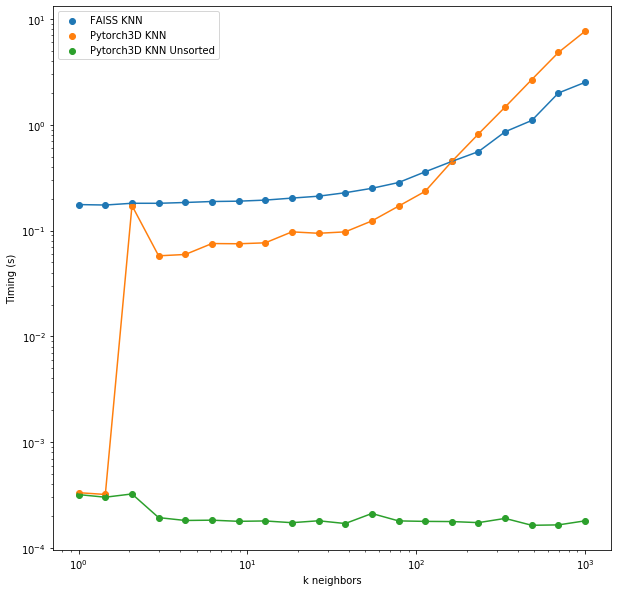

In [58]:
plt.figure(figsize=(10,10))
ax = plt.subplot()
plt.scatter(k_ticks, k_brute_gpu_timings, label="FAISS KNN")
plt.plot(k_ticks, k_brute_gpu_timings)
plt.scatter(k_ticks, k_3d_sorted_timings, label="Pytorch3D KNN")
plt.plot(k_ticks, k_3d_sorted_timings)
plt.scatter(k_ticks, k_3d_unsorted_timings, label="Pytorch3D KNN Unsorted")
plt.plot(k_ticks, k_3d_unsorted_timings)
plt.xscale("log")
plt.yscale("log")
ax.set_xlabel("k neighbors")
ax.set_ylabel("Timing (s)")
legend = ax.legend(loc='upper left')

## Total Equivalency??

In [64]:
_, I = faiss.knn_gpu(res, xb_pt.squeeze(), xb_pt.squeeze(), 100)

In [65]:
I, _ = torch.sort(I, axis=1)

In [66]:
knn_unsorted = ops.knn_points(xb_pt, xb_pt, K=100, return_sorted=False)

In [67]:
knn_sorted = ops.knn_points(xb_pt, xb_pt, K=100, return_sorted=True)

In [68]:
knn_unsorted, _ = torch.sort(knn_unsorted.idx[0], axis=1)

In [69]:
knn_sorted, _ = torch.sort(knn_sorted.idx[0], axis=1)

In [70]:
torch.equal(knn_unsorted, knn_sorted)

True

In [71]:
torch.equal(knn_unsorted, I)

False

In [72]:
torch.where(knn_unsorted != I)

(tensor([12216, 12216, 12216, 12216, 12216, 12216, 12216, 12216, 12216, 12216,
         12216, 12216, 12216, 12216, 12216, 12216, 12216, 12216, 12216, 12216,
         12216, 12216, 12216, 12216, 12216, 12216, 12216, 12216, 12216, 12216,
         12216, 12216, 12216, 12216, 12216, 12216, 12216, 12216, 12216, 12216,
         12216, 12216, 12216, 12216, 12216, 12216, 12216, 12216, 12216, 12216,
         12216, 12216, 12216, 12216, 12216, 12216, 12216, 12216, 12216, 12216,
         15469, 15469, 15469, 15469, 15469, 15469, 15469, 15469, 15469, 15469,
         15469, 15469, 15469, 15469, 15469, 15469, 15469, 15469, 15469, 15469,
         15469, 15469, 15469, 15469, 15469, 15469, 15469, 15469, 15469, 17794,
         17794, 17794, 17794, 17794, 17794, 17794, 17794, 17794, 17794, 17794,
         17794, 17794, 17794, 17794, 17794, 17794, 17794, 17794, 17794, 17794,
         17794, 17794, 17794, 17794, 17794, 17794, 17794, 17794, 17794, 17794,
         17794, 17794, 17794, 17794, 17794, 17794, 1

## Edge Making Equivalency

In [6]:
import faiss.contrib.torch_utils

In [330]:
from pytorch3d import _C

In [429]:
%%time
idx, dists = _C.knn_points_idx(p1, p2, lengths1, lengths2, 30, -1)
idx[0][dists[0] <= r_max**2]

CPU times: user 282 ms, sys: 91 ms, total: 373 ms
Wall time: 372 ms


tensor([    0,     1,     2,  ..., 99997, 99998, 99999], device='cuda:0')

In [426]:
%%time
P1 = p1.shape[1]
P2 = p2.shape[1]
lengths1 = torch.full((p1.shape[0],), P1, dtype=torch.int64, device=p1.device)
lengths2 = torch.full((p1.shape[0],), P2, dtype=torch.int64, device=p1.device)

CPU times: user 119 µs, sys: 0 ns, total: 119 µs
Wall time: 123 µs


In [108]:
res = faiss.StandardGpuResources()

In [313]:
r_max = 0.3

In [324]:
%%time
xb = np.random.random((nb, d)).astype('float32')
xb_pt = torch.from_numpy(xb).to("cuda")

CPU times: user 3.29 ms, sys: 0 ns, total: 3.29 ms
Wall time: 2.87 ms


In [325]:
%%time

knn_object = ops.knn_points(xb_pt.unsqueeze(0), xb_pt.unsqueeze(0), K=100, return_sorted=False)
print(knn_object.idx)
# I = knn_object.idx[0]
# D = knn_object.dists[0]
# ind = torch.Tensor.repeat(torch.arange(I.shape[0], device=device), (I.shape[1], 1), 1).T
# in_radius = D <= r_max**2
# edge_list = torch.stack([ind[D <= r_max**2], I[D <= r_max**2]])

tensor([[[    0, 10254, 92187,  ..., 10297, 22869, 28228],
         [10051,     1, 13303,  ..., 76185, 91054, 64175],
         [ 1988, 12788,     2,  ..., 33214, 63443, 86827],
         ...,
         [94398, 82126, 70967,  ..., 17696, 52275,  3420],
         [17041, 67339, 52803,  ...,  5976, 51510, 57131],
         [51452, 46358, 48241,  ..., 72212, 96468, 33632]]], device='cuda:0')
CPU times: user 152 ms, sys: 52.2 ms, total: 205 ms
Wall time: 204 ms


In [329]:
%%time

knn_object = ops.knn_points(xb_concat, xb_concat, K=100, return_sorted=False)
print(knn_object.idx[0])
# I = knn_object.idx[0]
# D = knn_object.dists[0]
# ind = torch.Tensor.repeat(torch.arange(I.shape[0], device=device), (I.shape[1], 1), 1).T
# in_radius = D <= r_max**2
# edge_list = torch.stack([ind[D <= r_max**2], I[D <= r_max**2]])

tensor([[    0, 97338, 83293,  ...,  2209, 71958, 12035],
        [78731,     1, 75095,  ..., 46003, 33042, 20302],
        [94440, 64814,     2,  ..., 49306, 64743, 73062],
        ...,
        [41074, 14368, 16743,  ..., 74606, 13156, 76279],
        [18671, 39613, 36430,  ..., 48452,  5066, 18505],
        [79542, 57357, 26416,  ..., 83471,  1282, 72407]], device='cuda:0')
CPU times: user 2.64 s, sys: 776 ms, total: 3.42 s
Wall time: 3.42 s


In [296]:
%%time
print(knn_object.idx)

tensor([[[    0, 77253, 93244,  ..., 94116, 41362, 48348],
         [66102,     1, 21511,  ..., 51498, 82276, 54818],
         [96924, 61209,     2,  ..., 44820, 96316,  7229],
         ...,
         [51307,  7360, 43426,  ...,  9164, 99078, 55078],
         [47920, 80765, 10133,  ...,  2923, 46027, 44837],
         [37062, 54467, 99999,  ..., 56134, 39525, 87827]]], device='cuda:0')
CPU times: user 1.33 ms, sys: 653 µs, total: 1.98 ms
Wall time: 1.66 ms


In [254]:
%%time
I_cpu = I.to("cpu")
D_cpu = D.to("cpu")
ind_cpu = ind.to("cpu")

CPU times: user 114 ms, sys: 153 ms, total: 266 ms
Wall time: 265 ms


In [262]:
%%time
ind_cpu[D_cpu <= r_max**2]

CPU times: user 161 ms, sys: 484 µs, total: 162 ms
Wall time: 103 ms


tensor([    0,     0,     0,  ..., 99999, 99999, 99999])

In [236]:
%%time
knn_object = ops.knn_points(xb_pt.unsqueeze(0), xb_pt.unsqueeze(0), K=200, return_sorted=False, return_nn=True)

CPU times: user 439 ms, sys: 124 ms, total: 563 ms
Wall time: 562 ms


In [228]:
%%time
print(knn_object[0])

tensor([[[0.0000, 0.2504, 0.2281,  ..., 0.2557, 0.2420, 0.1677],
         [0.1699, 0.0000, 0.0653,  ..., 0.1864, 0.1070, 0.1468],
         [0.1492, 0.1345, 0.0000,  ..., 0.2129, 0.2714, 0.2543],
         ...,
         [0.1886, 0.1908, 0.1716,  ..., 0.1228, 0.1673, 0.1810],
         [0.1251, 0.1739, 0.1624,  ..., 0.1567, 0.1720, 0.1733],
         [0.1586, 0.2160, 0.2659,  ..., 0.1545, 0.1833, 0.2281]]],
       device='cuda:0')
CPU times: user 329 ms, sys: 113 ms, total: 442 ms
Wall time: 441 ms


In [211]:
%%time
knn_object.dists[0]

CPU times: user 20 µs, sys: 10 µs, total: 30 µs
Wall time: 31.9 µs


tensor([[0.0000, 0.2767, 0.3177,  ..., 0.1754, 0.2580, 0.3317],
        [0.2505, 0.0000, 0.2266,  ..., 0.1616, 0.2388, 0.1991],
        [0.3576, 0.3259, 0.0000,  ..., 0.2855, 0.3752, 0.2697],
        ...,
        [0.2356, 0.1651, 0.2214,  ..., 0.2082, 0.1545, 0.2206],
        [0.0515, 0.2430, 0.2357,  ..., 0.2008, 0.1911, 0.1864],
        [0.2134, 0.2127, 0.3615,  ..., 0.3402, 0.1883, 0.3476]],
       device='cuda:0')

In [212]:
%%time
I, D

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.01 µs


(tensor([[    0, 14881, 65497,  ...,   913, 22800, 79311],
         [97777,     1, 44033,  ..., 46287, 64841, 57255],
         [98379,  2961,     2,  ..., 51836, 71521, 54336],
         ...,
         [33218, 74590, 36060,  ..., 14629, 70337, 55657],
         [ 2923, 40832, 10583,  ..., 84957, 92123, 58598],
         [91895, 29504, 75248,  ..., 58607, 50481, 10077]], device='cuda:0'),
 tensor([[0.0000, 0.2767, 0.3177,  ..., 0.1754, 0.2580, 0.3317],
         [0.2505, 0.0000, 0.2266,  ..., 0.1616, 0.2388, 0.1991],
         [0.3576, 0.3259, 0.0000,  ..., 0.2855, 0.3752, 0.2697],
         ...,
         [0.2356, 0.1651, 0.2214,  ..., 0.2082, 0.1545, 0.2206],
         [0.0515, 0.2430, 0.2357,  ..., 0.2008, 0.1911, 0.1864],
         [0.2134, 0.2127, 0.3615,  ..., 0.3402, 0.1883, 0.3476]],
        device='cuda:0'))

In [213]:
%%time
ind = torch.Tensor.repeat(torch.arange(I.shape[0], device=device), (I.shape[1], 1), 1).T

CPU times: user 0 ns, sys: 1.36 ms, total: 1.36 ms
Wall time: 1.08 ms


In [201]:
ind

tensor([[    0,     0,     0,  ...,     0,     0,     0],
        [    1,     1,     1,  ...,     1,     1,     1],
        [    2,     2,     2,  ...,     2,     2,     2],
        ...,
        [99997, 99997, 99997,  ..., 99997, 99997, 99997],
        [99998, 99998, 99998,  ..., 99998, 99998, 99998],
        [99999, 99999, 99999,  ..., 99999, 99999, 99999]], device='cuda:0')

In [194]:
%%time
edge_list = torch.stack([ind[D <= r_max**2], I[D <= r_max**2]])
# Remove self-loops
edge_list = edge_list[:, edge_list[0] != edge_list[1]]

CPU times: user 2.16 ms, sys: 1.04 ms, total: 3.19 ms
Wall time: 2.79 ms


In [195]:
edge_list.shape

torch.Size([2, 1381130])

In [322]:
xb = np.random.random((nb, d)).astype('float32')
xb_pt = torch.from_numpy(xb).to("cuda")

In [323]:
%%time
D, I = faiss.knn_gpu(res, xb_pt.squeeze(), xb_pt.squeeze(), 100)
print(I)

tensor([[    0, 88906, 75235,  ..., 83399, 43286, 83023],
        [    1, 97447, 70750,  ..., 17177, 18546, 91704],
        [    2,  5301, 89930,  ..., 97846, 73235, 23308],
        ...,
        [99997, 42925, 18030,  ..., 77772, 45766, 16716],
        [99998, 93619, 71839,  ..., 65737, 99443,  9563],
        [99999, 44145, 56005,  ..., 47270, 33549, 67971]], device='cuda:0')
CPU times: user 156 ms, sys: 56.2 ms, total: 213 ms
Wall time: 212 ms


In [180]:
%%time
ind = torch.Tensor.repeat(torch.arange(I.shape[0], device=device), (I.shape[1], 1), 1).T
edge_list = torch.stack([ind[D <= r_max**2], I[D <= r_max**2]])

CPU times: user 3.24 ms, sys: 0 ns, total: 3.24 ms
Wall time: 2.86 ms


In [185]:
ind

tensor([[    0,     0,     0,  ...,     0,     0,     0],
        [    1,     1,     1,  ...,     1,     1,     1],
        [    2,     2,     2,  ...,     2,     2,     2],
        ...,
        [99997, 99997, 99997,  ..., 99997, 99997, 99997],
        [99998, 99998, 99998,  ..., 99998, 99998, 99998],
        [99999, 99999, 99999,  ..., 99999, 99999, 99999]], device='cuda:0')

In [181]:
%%time
# Remove self-loops
edge_list = edge_list[:, edge_list[0] != edge_list[1]]

CPU times: user 276 µs, sys: 132 µs, total: 408 µs
Wall time: 261 µs


In [131]:
edge_list.shape

torch.Size([2, 1375012])

In [145]:
xb = np.random.random((nb, d)).astype('float32')
xb_pt = torch.from_numpy(xb).to("cuda")

In [152]:
%%time
for i in range(10):
    edge_list = build_edges(xb_pt, 0.3, 200)

CPU times: user 19 s, sys: 6.45 s, total: 25.4 s
Wall time: 25.4 s


In [415]:
xb = np.random.random((nb, d)).astype('float32')
xb_pt = torch.from_numpy(xb).to("cuda")

In [428]:
%%time
for k in np.arange()
edge_list = build_edges(xb_pt, 0.3, 20, use_faiss=True)

CPU times: user 140 ms, sys: 184 ms, total: 323 ms
Wall time: 323 ms


In [11]:
k_timings = []
k_ticks = np.logspace(0, 2.8, num=20, base=10)
for k in k_ticks:
    tic = tt()
    edge_list = build_edges(xb_pt, 0.3, int(k))
    k_timing = tt() - tic
    k_timings.append(k_timing)
    
    print("{} nbs in {} seconds".format(k, k_timing))

1.0 nbs in 0.06000471115112305 seconds
1.404004245548316 nbs in 0.059882164001464844 seconds
1.9712279215176958 nbs in 0.0597994327545166 seconds
2.767612370754227 nbs in 0.06099104881286621 seconds
3.885739518570975 nbs in 0.06192827224731445 seconds
5.455594781168519 nbs in 0.08217763900756836 seconds
7.659678234751834 nbs in 0.08052968978881836 seconds
10.754220761125605 nbs in 0.0870206356048584 seconds
15.098971606184193 nbs in 0.12217330932617188 seconds
21.199020238496082 nbs in 0.21349859237670898 seconds
29.76351441631318 nbs in 0.3493661880493164 seconds
41.78810060294221 nbs in 0.38930773735046387 seconds
58.67067065993098 nbs in 0.39064860343933105 seconds
82.37387069571011 nbs in 0.4042544364929199 seconds
115.65326417902502 nbs in 0.4029724597930908 seconds
162.3776739188721 nbs in 0.4707655906677246 seconds
227.97894356435648 nbs in 0.47101807594299316 seconds
320.08340465997645 nbs in 0.6698033809661865 seconds
449.3984590721666 nbs in 0.6734185218811035 seconds
630.957

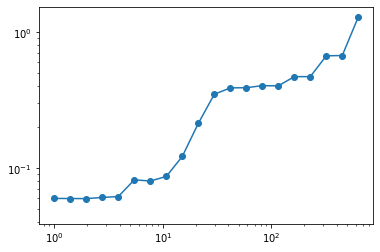

In [15]:
plt.scatter(k_ticks, k_timings)
plt.plot(k_ticks, k_timings)
plt.xscale("log")
plt.yscale("log")